In [3]:
import rasterio
from rasterio.plot import show
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
###Load Labelled data ###
gt = rasterio.open('rasterize_on_sentinel_2_labelled_17SLD.tif')
gt = gt.read(1)
gt = np.reshape(gt, (10980,10980,1))
gt.shape

(10980, 10980, 1)

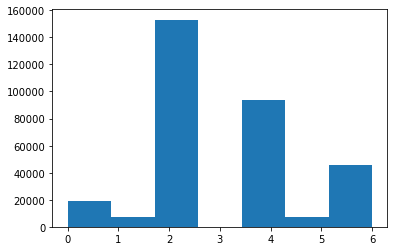

In [5]:
from matplotlib import pyplot as plt
plt.hist(gt.ravel(),7,[0,6])
plt.show()

In [6]:
###Load bands of satellite data #####

band_blue = rasterio.open('S2_17SLD_2019-09-15_masked_warped-20201024T122146Z-001/S2_17SLD_2019-09-15_masked_warped/T17SLD_20190922T203454_B02_10m.tif')

band_green = rasterio.open('S2_17SLD_2019-09-15_masked_warped-20201024T122146Z-001/S2_17SLD_2019-09-15_masked_warped/T17SLD_20190922T203454_B03_10m.tif')

band_red = rasterio.open('S2_17SLD_2019-09-15_masked_warped-20201024T122146Z-001/S2_17SLD_2019-09-15_masked_warped/T17SLD_20190922T203454_B04_10m.tif')

band_8 = rasterio.open('S2_17SLD_2019-09-15_masked_warped-20201024T122146Z-001/S2_17SLD_2019-09-15_masked_warped/T17SLD_20190922T203454_B08_10m.tif')



Text(0.5, 1.0, 'Panchromatic')

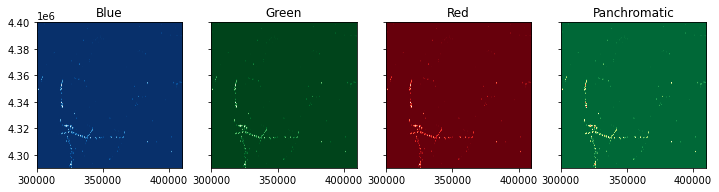

In [7]:
#Plot different bands

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 10), sharey=True)
show((band_blue, 1), cmap='Blues', ax=ax1)
show((band_green, 1), cmap='Greens', ax=ax2)
show((band_red, 1), cmap='Reds', ax=ax3)
show((band_8, 1), cmap='RdYlGn', ax=ax4)

ax1.set_title("Blue")
ax2.set_title("Green")
ax3.set_title("Red")
ax4.set_title("Panchromatic")

In [8]:
band_blue = band_blue.read(1)
band_green = band_green.read(1)
band_red = band_red.read(1)
band_8= band_8.read(1)
train_data = np.stack((band_blue, band_green, band_red, band_8), axis=-1) 

In [9]:
band_blue.mean()
band_green.mean()
band_red.mean()
band_8.mean()


65340.909417146926

In [10]:
train_data = cv2.normalize(train_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
train_data.shape

(10980, 10980, 4)

In [11]:
label_values = [0,1,2,3,4,5,6]

In [12]:
def one_hot_it(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

In [13]:
sem = one_hot_it(gt,label_values)
sem.shape

(10980, 10980, 7)

In [14]:
###generate Random patches###

def get_patches(img, gt, n_patches, sz=224):
    x = list()
    y = list()
    total_patches = 0
    while total_patches < n_patches:
        img_patch, mask_patch = get_random_patch(img, gt, sz)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    print('Generated {} patches'.format(total_patches))
    return np.array(x), np.array(y)

In [15]:
def get_random_patch(img, mask, sz=224):
    """
    :param img: ndarray with shape (x, y, num_channels)
    :param mask: gt ndarray with shape (x, y, num_classes)
    :param sz: size of random patch
    :return: patch with shape (sz, sz, num_channels)
    """
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    patch_img = img[xc:(xc + sz), yc:(yc + sz)]
    patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]
    
    return patch_img, patch_mask

In [16]:
import random
train_x, train_y = get_patches(train_data,sem,2000)

Generated 2000 patches


In [17]:
train_x.shape

(2000, 224, 224, 4)

In [18]:
train_y.shape

(2000, 224, 224, 7)

In [19]:
# Build model
from UNet import get_model
model = get_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
from tensorflow.keras import backend as K
def weighted_categorical_crossentropy(weights):

    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        y_pred = K.cast(y_pred, dtype='float32')
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
optimizer = Adam(lr=0.0001, amsgrad=True)
weights=np.array([0.1,0.2,0.015,0.4,0.035,0.2,0.05])
model.compile(optimizer=optimizer, loss=weighted_categorical_crossentropy(weights),metrics=[MeanIoU(num_classes=7)] )



In [22]:
import os
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
checkpoint_path = "Unet_remote_sensing/cp.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = []  # Callbacks

callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss',
                                           verbose=1, save_best_only=False, save_weights_only=True, mode='min',
                                           period=5))
logdir = "logs_unet_remote_sensing/unet" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks.append(TensorBoard(log_dir=logdir))
print('Ready for training!\n')
history = model.fit(train_x, train_y, epochs=10, batch_size=16, shuffle=True, callbacks=callbacks, validation_split=0.2) 

Ready for training!

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 24s 15ms/sample - loss: 0.0013 - mean_io_u: 0.5061 - val_loss: 0.0013 - val_mean_io_u: 0.5905
Epoch 2/10
1600/1600 [==============================] - 20s 12ms/sample - loss: 0.0013 - mean_io_u: 0.5103 - val_loss: 0.0012 - val_mean_io_u: 0.6096
Epoch 3/10
1600/1600 [==============================] - 20s 12ms/sample - loss: 0.0012 - mean_io_u: 0.5183 - val_loss: 0.0013 - val_mean_io_u: 0.5855
Epoch 4/10
1600/1600 [==============================] - 20s 12ms/sample - loss: 0.0011 - mean_io_u: 0.4988 - val_loss: 0.0011 - val_mean_io_u: 0.5264
Epoch 5/10
1584/1600 [============================>.] - ETA: 0s - loss: 0.0011 - mean_io_u: 0.4947
Epoch 00005: saving model to Unet_remote_sensing/cp.ckpt
1600/1600 [==============================] - 20s 13ms/sample - loss: 0.0011 - mean_io_u: 0.4947 - val_loss: 0.0016 - val_mean_io_u: 0.5078
Epoch 6/10
1600/1600 [===============

### References:
1. https://keras.io/examples/vision/oxford_pets_image_segmentation/